In [1]:
#!pip install torchsummary
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

c:\Pyhton\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
with open('cifar/cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar/cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [39, 58, 23]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCWC -> NWHC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

In [15]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader

In [18]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

In [19]:
class Cifar100_CNN(nn.Module):
    def __init__(self, _seq : nn.Sequential):
        super(Cifar100_CNN, self).__init__()
        self.seq =_seq

    def forward(self, input):
        return self.seq(input)

# Инициализация моделей

In [20]:
HIDDEN_SIZE = 32
NUM_OF_CLASSES = 3

In [21]:
# Изначальная конфигурация
# Conv2d(3, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
# Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# AvgPool2d(kernel_size=4, stride=4, padding=0)

def seq_1():
    return nn.Sequential(
        Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
        nn.Conv2d(3, HIDDEN_SIZE, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2)),
        nn.ReLU(),
        nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.AvgPool2d(4),
        nn.Flatten(),
        nn.Linear(HIDDEN_SIZE*8, NUM_OF_CLASSES),
    )

def model_1():
    return Cifar100_CNN(seq_1())

In [22]:
# добавили слой усредняющего пуллинга после первого
# Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
# AvgPool2d(kernel_size=4, stride=4, padding=0)
# Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# AvgPool2d(kernel_size=4, stride=4, padding=0)

def seq_2(): 
    return nn.Sequential(
        Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
        nn.Conv2d(3, HIDDEN_SIZE, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=4, stride=4, padding=0),
        nn.ReLU(),
        nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.AvgPool2d(4),
        nn.Flatten(),
        nn.Linear(HIDDEN_SIZE*8, NUM_OF_CLASSES),
    )

def model_2():
    return Cifar100_CNN(seq_2())

In [23]:
# заменили усредняющий слой пуллинга на макс пуллинг после первого
# Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
# MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
# Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# AvgPool2d(kernel_size=4, stride=4, padding=0)

def seq_3():
    return nn.Sequential(
    Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
    nn.Conv2d(3, HIDDEN_SIZE, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
    nn.ReLU(),
    nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(),
    nn.AvgPool2d(4),
    nn.Flatten(),
    nn.Linear(HIDDEN_SIZE*8, NUM_OF_CLASSES),
)

def model_3(): 
    return Cifar100_CNN(seq_3())

In [109]:
# step, pooling, pooling

def seq_configuration(stride:int, kernel:int, pooling_1:str, pooling_2:str):
    pool1 = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
    pool2 = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
    if pooling_1 == "avg":
        pool1 = nn.AvgPool2d(4)
    if pooling_2 == "avg":
        pool2 = nn.AvgPool2d(4)
    return nn.Sequential(
    Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
    nn.Conv2d(3, HIDDEN_SIZE, kernel_size=(kernel, kernel), stride=(1, 1), padding=(2, 2)),
    nn.ReLU(),
    pool1,
    nn.ReLU(),
    nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(),
    pool2,
    nn.Flatten(),
    nn.Linear(HIDDEN_SIZE*8, NUM_OF_CLASSES),
)

def model_configuration(stride:int, kernel:int,  pooling_1:str, pooling_2:str): 
    return Cifar100_CNN(seq_configuration(stride, kernel, pooling_1, pooling_2))

# Работа с моделями

In [134]:
# Глобальные параметры
EPOCHS = 60
LEARNING_RATE = 0.005

In [135]:
# заменить на требуемую
model = model_configuration(stride=1, kernel=3, pooling_1="max", pooling_2="max")
# NEW
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))
model

tensor([[-0.5470,  0.3948,  0.3774]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 32, 34, 34]             896
              ReLU-3           [-1, 32, 34, 34]               0
         MaxPool2d-4             [-1, 32, 8, 8]               0
              ReLU-5             [-1, 32, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]          18,496
              ReLU-7             [-1, 64, 8, 8]               0
         MaxPool2d-8             [-1, 64, 2, 2]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                    [-1, 3]             771
Total params: 20,163
Trainable params: 20,163
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=3, bias=True)
  )
)

100%|██████████| 720/720 [00:16<00:00, 43.26it/s]


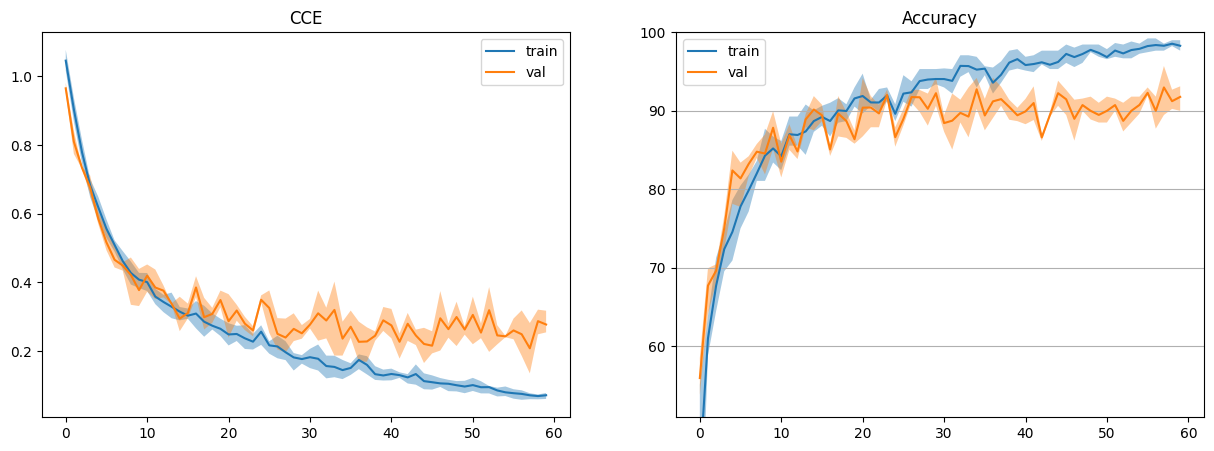

Обучение закончено за 49.20967125892639 секунд


In [136]:

REDRAW_EVERY = 20
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    #running_loss = 0.0
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)

    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))

    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            #running_loss += loss.item()
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))

    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
print('Обучение закончено за %s секунд' % passed)

## Проверка качества модели по классам на обучающей и тестовой выборках

In [137]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

          39     0.9559    0.9960    0.9755       500
          58     0.9979    0.9480    0.9723       500
          23     0.9881    0.9960    0.9920       500

    accuracy                         0.9800      1500
   macro avg     0.9806    0.9800    0.9800      1500
weighted avg     0.9806    0.9800    0.9800      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          39     0.8909    0.9800    0.9333       100
          58     0.9438    0.8400    0.8889       100
          23     0.9307    0.9400    0.9353       100

    accuracy                         0.9200       300
   macro avg     0.9218    0.9200    0.9192       300
weighted avg     0.9218    0.9200    0.9192       300

--------------------------------------------------


In [117]:
# сохраниение модели
# ПЕРВЫЙ СПОСОБ: сохранение параметров
#PATH = 'cifar_cnn.pth'
#torch.save(model.state_dict(), PATH)
# загрузка
#new_model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
#new_model.load_state_dict(torch.load(PATH))
#new_model.eval()

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_cnn.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [118]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})

In [79]:
#pip install intel_extension_for_pytorch

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement intel_extension_for_pytorch (from versions: none)
ERROR: No matching distribution found for intel_extension_for_pytorch


In [120]:
from copy import deepcopy
state_dict_backup = deepcopy(model.state_dict())

In [121]:
def generate_theta(seed=None):
    model.eval()
    model.load_state_dict(state_dict_backup)
    if seed is not None:
        np.random.seed(seed)
    params = []
    with torch.no_grad():
        for w in model.parameters():
            params.append(w.detach().cpu().numpy())
    params_n = np.concatenate([p.flatten() for p in params]).size
    random_theta_flat = np.random.normal(size=params_n)
    random_theta = []
    offset = 0
    for p in params:
        p_weights = p.flatten().size
        random_theta.append(random_theta_flat[offset:offset+p_weights].\
                            reshape(*p.shape))
        # normalization
        rank = random_theta[-1].shape.__len__()
        if rank == 4: # convolution
            #print('Conv')
            # Frobenius norm
            norm_r = np.sqrt((random_theta[-1]**2).sum(axis=-1).sum(axis=-1))
            norm_p = np.sqrt((p**2).sum(axis=-1).sum(axis=-1))
            norm = (norm_p / norm_r).reshape(*norm_p.shape, 1, 1)
        elif rank == 2: # fully connected
            #print('FC')
            norm_r = np.sqrt((random_theta[-1]**2).sum(axis=-1))
            norm_p = np.sqrt((p**2).sum(axis=-1))
            norm = (norm_p / norm_r).reshape(-1, 1)
        elif rank == 1: # bias
            #print('bias')
            norm_r = np.sqrt((random_theta[-1]**2).sum())
            norm_p = np.sqrt((p**2).sum())
            norm = norm_p / norm_r
        random_theta[-1] = random_theta[-1]*norm
        offset += p_weights
    assert offset==params_n, \
            "Not all params are utilized. Expected %d, found %d"%(params_n, offset)
    return random_theta

theta1 = generate_theta(seed=0)
theta2 = generate_theta(seed=1011)

In [122]:
criterion2 = nn.CrossEntropyLoss(reduction='none')
loss_curve = []
alphas = np.arange(-1500, 1500, step=5)/1000
for alpha in tqdm(alphas):
    state_dict = model.state_dict()
    for (k, v), v_new in zip(state_dict_backup.items(), theta1):
        tensor = v.clone().detach() + \
              alpha*(torch.tensor(v_new, device=device) - v.clone().detach())
        state_dict[k] = tensor
    model.load_state_dict(state_dict)
    loss = []

    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).detach()
            loss.append(criterion2(outputs, labels).detach().cpu().numpy())
    loss_curve.append(np.concatenate(loss).mean())

100%|██████████| 600/600 [00:46<00:00, 12.89it/s]


Text(0, 0.5, 'CCE, log10')

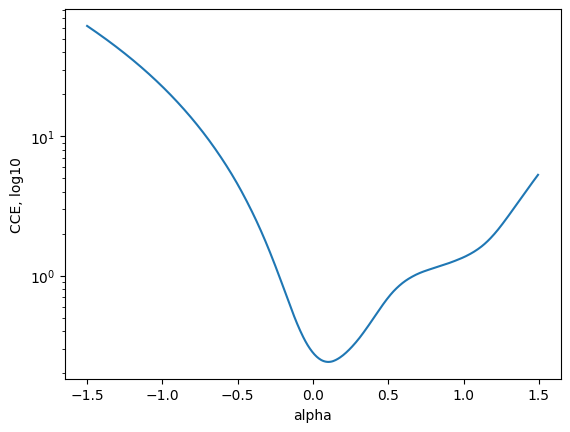

In [123]:
plt.plot(alphas, loss_curve)
plt.yscale('log')
plt.xlabel('alpha')
plt.ylabel('CCE, log10')

In [124]:
# увеличив step, можно значительно ускорить вычисления
# однако вместе с этим теряется разрешение
alphas = []
vals = np.arange(-150, 151, step=5)/100
size = vals.size

# создаём заданный растр
for a1 in vals:
    for a2 in vals:
        alphas.append((a1, a2))

alphas = np.array(alphas)

In [125]:
Z = []
for a1, a2 in tqdm(alphas):
    state_dict = model.state_dict()
    for (k, v), v_new, v_new2 in zip(state_dict_backup.items(), theta1, theta2):
        # линейная интерполяция
        tensor = v.clone().detach() + \
                 a1*(torch.tensor(v_new, device=device) - \
                     v.clone().detach())
        # ещё раз со вторым вектором
        tensor = tensor + a2*(torch.tensor(v_new2, device=device) - tensor)
        state_dict[k] = tensor
        #print(k, tensor, v_new)
    model.load_state_dict(state_dict)
    loss = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).detach()#.cpu().numpy()
            loss.append(criterion2(outputs, labels).detach().cpu().numpy())
    Z.append(np.concatenate(loss).mean())
ZZ = np.array(Z)

100%|██████████| 3721/3721 [06:15<00:00,  9.91it/s]


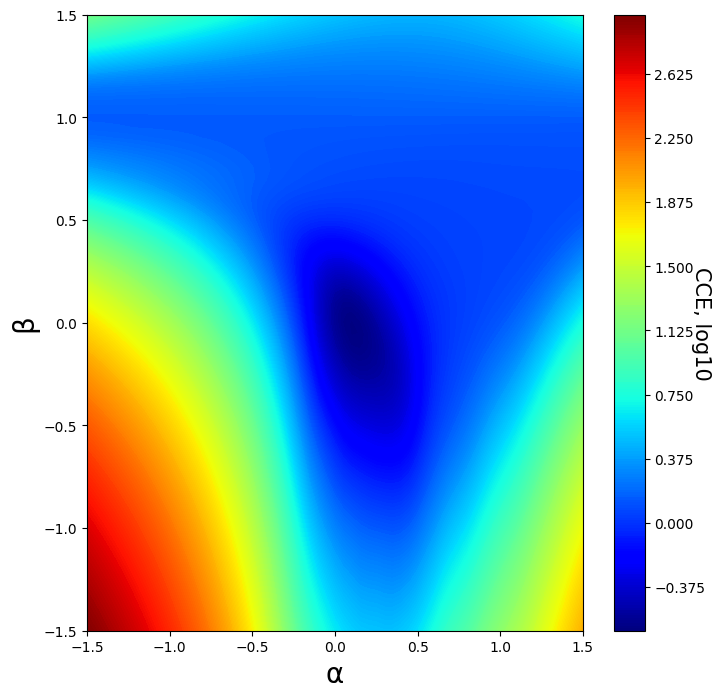

In [126]:
# настройка размера графика
plt.figure(figsize=(8, 8))
# отрисовка закрашенных контуров, аналогично 2 части 1 ЛР
cs = plt.contourf(alphas[:,0].reshape(size, size),
             alphas[:,1].reshape(size, size),
             np.log10(ZZ.reshape(size, size)),
             levels=255,
             cmap=plt.cm.jet,
             )
# установка цветовой шкалы и её названия
plt.colorbar(cs).ax.set_ylabel('CCE, log10', rotation=270, fontsize=15)
# установка названий осям X, Y
plt.xlabel('α', fontsize=20)
plt.ylabel('β', fontsize=20)
plt.show()

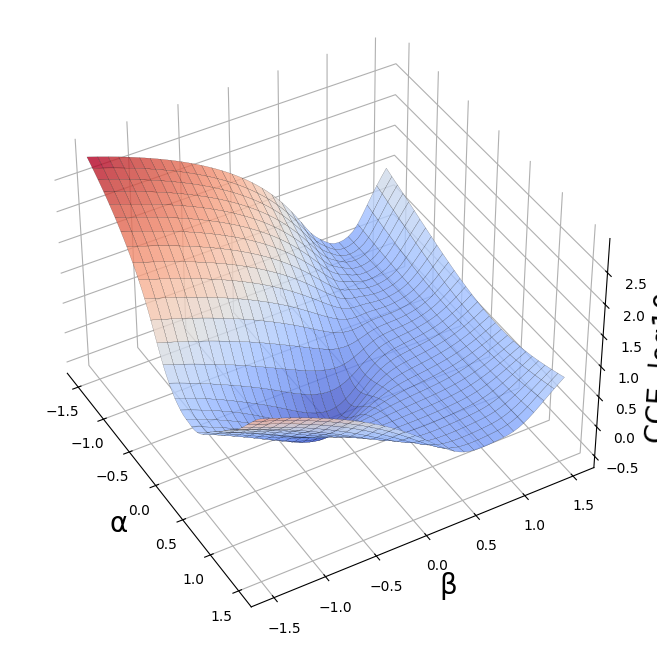

In [127]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
# установка названий осям X, Y и Z
ax.set_xlabel('α', fontsize=20)
ax.set_ylabel('β', fontsize=20)
ax.set_zlabel('CCE, log10', fontsize=20)
# выставление прозрачности сетки, для красоты
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# отрисовка 3D поверхности, данные для отрисовки аналогичны contourf
surf = ax.plot_surface(alphas[:,0].reshape(size, size),
                       alphas[:,1].reshape(size, size),
                       np.log10(ZZ.reshape(size, size)),
                       cmap=plt.cm.coolwarm,
                       linewidth=0.1,
                       edgecolors='k',
                       alpha=0.8,
                       antialiased=True)
# первый агрумент - вращение вокруг XY, второрй аргумент - вокруг YZ
ax.view_init(40, -30)